In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
###############################################
################ 1 数据处理部分 ################
###############################################

###############
# 数据读取
# 路径
train_path = 'C:/Users/zhang/mine/finTech/data/A/new/训练数据集'
pred_path = 'C:/Users/zhang/mine/finTech/data/A/new/评分数据集'
save_path = 'C:/Users/zhang/mine/finTech/data/A'

# 读入数据
train_tag_DF = pd.read_csv(train_path + '/训练数据集_tag.csv')
train_trd_DF = pd.read_csv(train_path + '/训练数据集_trd.csv')
train_beh_DF = pd.read_csv(train_path + '/训练数据集_beh.csv')
train_trd_DF.drop_duplicates(inplace = True)
train_beh_DF.drop_duplicates(inplace = True)

# Tag部分处理

In [2]:
################
# tag数据处理
########
# train部分
########
# 丢弃无用列
train_tag_DF.drop(['edu_deg_cd', 'deg_cd', 'atdd_type',
                   ], axis = 1, inplace = True)

# 填补 \N ~数据
train_tag_DF.loc[train_tag_DF['job_year'] == '\\N', 'job_year'] = '-1'

strColName = ['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd']
colname = train_tag_DF.columns.values.tolist()
for col in colname[1:]:
    if col in strColName:
        train_tag_DF[col] = train_tag_DF[col].fillna('Unknown')
        train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = 'Unknown'
        train_tag_DF.loc[train_tag_DF[col] == '~', col] = 'Unknown'
    if (not np.issubdtype(train_tag_DF[col], np.int64)):
        if ('0' in train_tag_DF[col].value_counts().index.tolist()) and ('-1' in train_tag_DF[col].value_counts().index.tolist()):
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '-2'
        elif ('0' in train_tag_DF[col].value_counts().index.tolist()):
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '-1'
        else:
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '0'
     
for col in colname[1:]:
    if (not np.issubdtype(train_tag_DF[col], np.int64)) and (col not in strColName):
        train_tag_DF[col] = train_tag_DF[col].astype(np.int64)

train_tag_DF['I12_mon_whl_tms'] = train_tag_DF[['l12mon_buy_fin_mng_whl_tms',
                                                'l12_mon_fnd_buy_whl_tms',
                                                'l12_mon_insu_buy_whl_tms',
                                                'l12_mon_gld_buy_whl_tms']].apply(lambda x: x.fillna(0).astype(np.int).sum(), axis = 1).astype(np.int64)
# 理财产品、基金、保险、黄金购买次数总和

train_tag_DF['dnl_ind'] = train_tag_DF[['dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind']].apply(lambda x: x.sum(), axis = 1)
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind',

train_tag_DF['cur_debit_card'] = train_tag_DF[['cur_debit_cnt', 
                                               'cur_debit_min_opn_dt_cnt', 
                                               'cur_debit_crd_lvl']].apply(lambda x: x[0] * x[1] * x[2] / 100, axis = 1)

train_tag_DF['cur_credit_card'] = train_tag_DF[[ 'cur_credit_cnt', 
                                                'cur_credit_min_opn_dt_cnt', 
                                                'hld_crd_card_grd_cd',
                                                'crd_card_act_ind']].apply(lambda x: x[0] * x[1] * (x[2] + 1e-5) * (x[3] + 1e-5), axis = 1)

train_tag_DF['ic_fr_sh_ind'] = train_tag_DF[['ic_ind', 'fr_or_sh_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: ic, 2: fr or sh, 3: both

train_tag_DF['hav_car_hou_ind'] = train_tag_DF[['hav_car_grp_ind',
                                                'hav_hou_grp_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: Car, 2: House, 3: both

train_tag_DF['ovd_cnt'] = train_tag_DF[['ovd_30d_loan_tot_cnt',
                                        'his_lng_ovd_day']].apply(lambda x: x[0] * x[1], axis = 1)

train_tag_DF['rsk_combine'] = train_tag_DF[['vld_rsk_ases_ind',
                                         'fin_rsk_ases_grd_cd',
                                         'confirm_rsk_ases_lvl_typ_cd',
                                         'cust_inv_rsk_endu_lvl_cd',
                                        ]].apply(lambda x: -abs(x[0]*x[1]*x[2]*x[3]) if any(x<0) else x[0]*x[1]*x[2]*x[3], axis = 1)

train_tag_DF['ast_combine'] = train_tag_DF[['tot_ast_lvl_cd',
                                         'pot_ast_lvl_cd',
                                        ]].apply(lambda x: -abs(x[0]*x[1]) if any(x<0) else x[0]*x[1], axis = 1)

train_tag_DF['rsk_mean'] = train_tag_DF[['vld_rsk_ases_ind',
                                         'fin_rsk_ases_grd_cd',
                                         'confirm_rsk_ases_lvl_typ_cd',
                                         'cust_inv_rsk_endu_lvl_cd',
                                        ]].apply(lambda x: x.mean(), axis = 1)

train_tag_DF['ast_mean'] = train_tag_DF[['tot_ast_lvl_cd',
                                         'pot_ast_lvl_cd',
                                        ]].apply(lambda x: x.mean(), axis = 1)


# Trx部分

In [3]:
################
# trx数据处理
#######
# train部分
# 交易一级、二级最高频代码
trx_cod1_cd = train_trd_DF.groupby(['id', 'Trx_Cod1_Cd'])['trx_tm'].count()
trx_cod1_cd = trx_cod1_cd.reset_index()
trx_cod1_cd.rename(columns = {'trx_tm': 'trx_cod1_tms'}, inplace = True)
trx_cod1_cd.sort_values(['id', 'trx_cod1_tms'], inplace = True)

trx_cod1_cd.drop_duplicates('id', keep = 'last', inplace = True)
trx_cod1_cd.drop(['trx_cod1_tms'], axis = 1, inplace = True)
trx_cod1_cd.rename(columns = {'Trx_Cod1_Cd': 'most_Trx_Cod1_Cd'}, inplace = True)


trx_cod2_cd = train_trd_DF.groupby(['id', 'Trx_Cod2_Cd'])['trx_tm'].count()
trx_cod2_cd = trx_cod2_cd.reset_index()
trx_cod2_cd.rename(columns = {'trx_tm': 'trx_cod2_tms'}, inplace = True)
trx_cod2_cd.sort_values(['id', 'trx_cod2_tms'], inplace = True)

trx_cod2_cd.drop_duplicates('id', keep = 'last', inplace = True)
trx_cod2_cd.drop(['trx_cod2_tms'], axis = 1, inplace = True)
trx_cod2_cd.rename(columns = {'Trx_Cod2_Cd': 'most_Trx_Cod2_Cd'}, inplace = True)

train_DF = pd.merge(train_tag_DF, trx_cod1_cd, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, trx_cod2_cd, on = 'id', how = 'left')

train_DF['most_Trx_Cod1_Cd'] = train_DF['most_Trx_Cod1_Cd'].fillna(0)
train_DF['most_Trx_Cod2_Cd'] = train_DF['most_Trx_Cod2_Cd'].fillna(0)

# 支出跟收入
# B: 支出, C: 收入
id_pay = train_trd_DF.groupby(['id', 'Dat_Flg1_Cd'])['cny_trx_amt'].sum().reset_index()

id_income = id_pay[id_pay['Dat_Flg1_Cd'] == 'C']
id_pay = id_pay[id_pay['Dat_Flg1_Cd'] == 'B']

id_income.reset_index(drop = True, inplace = True)
id_pay.reset_index(drop = True, inplace = True)

id_income.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)
id_pay.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)

id_income.rename(columns = {'cny_trx_amt': 'cny_trx_income'}, inplace = True)
id_pay.rename(columns = {'cny_trx_amt': 'cny_trx_pay'}, inplace = True)

id_income['cny_trx_income'] = id_income['cny_trx_income'].abs()
id_pay['cny_trx_pay'] = id_pay['cny_trx_pay'].abs()

####
# 跟tag合并
train_DF = pd.merge(train_DF, id_income, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_pay, on = 'id', how = 'left')

train_DF['cny_trx_income'] = train_DF['cny_trx_income'].fillna(0)
train_DF['cny_trx_pay'] = train_DF['cny_trx_pay'].fillna(0)
# 净收入\支出
train_DF['actual_income'] = train_DF[['cny_trx_income', 'cny_trx_pay']].apply(lambda x: x[0] - x[1], axis = 1)
#train_DF.head()

###
# 交易方式
trx_way = train_trd_DF.groupby(['id', 'Dat_Flg3_Cd'])['trx_tm'].count()
trx_way = trx_way.reset_index()
trx_way.rename(columns = {'trx_tm': 'trx_way_tms'}, inplace = True)
trx_way.sort_values(['id', 'trx_way_tms'], inplace = True)

trx_way.drop_duplicates('id', keep = 'last', inplace = True)
trx_way.drop(['trx_way_tms'], axis = 1, inplace = True)
trx_way.rename(columns = {'Dat_Flg3_Cd': 'most_trx_way'}, inplace = True)
train_DF = pd.merge(train_DF, trx_way, on = 'id', how = 'left')
train_DF['most_trx_way'] = train_DF['most_trx_way'].fillna('Undo')

# 交易次数
trx_tms = train_trd_DF.groupby(['id'])['trx_tm'].count()
trx_tms = trx_tms.reset_index()
trx_tms.rename(columns = {'trx_tm': 'trx_tms'}, inplace = True)
train_DF = pd.merge(train_DF, trx_tms, on = 'id', how = 'left')
train_DF['trx_tms'] = train_DF['trx_tms'].fillna(0)

trx_Dat_Flg1_Cd_cnt = pd.crosstab(train_trd_DF['id'],train_trd_DF['Dat_Flg1_Cd'])
trx_Dat_Flg1_Cd_cnt = trx_Dat_Flg1_Cd_cnt.reset_index()
temp_columns = trx_Dat_Flg1_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    trx_Dat_Flg1_Cd_cnt.rename(columns = {col: 'Dat_Flg1_Cd_' + col}, inplace = True)
train_DF = pd.merge(train_DF, trx_Dat_Flg1_Cd_cnt, on = 'id', how = 'left')

temp_columns = trx_Dat_Flg1_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)

trx_Dat_Flg3_Cd_cnt = pd.crosstab(train_trd_DF['id'],train_trd_DF['Dat_Flg3_Cd'])
trx_Dat_Flg3_Cd_cnt = trx_Dat_Flg3_Cd_cnt.reset_index()
temp_columns = trx_Dat_Flg3_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    trx_Dat_Flg3_Cd_cnt.rename(columns = {col: 'Dat_Flg3_Cd_' + col}, inplace = True)
train_DF = pd.merge(train_DF, trx_Dat_Flg3_Cd_cnt, on = 'id', how = 'left')

temp_columns = trx_Dat_Flg3_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)


# beh部分

In [4]:
################
# beh app数据处理
#######
# train部分
# 浏览页面
beh_page_no_cnt = pd.crosstab(train_trd_DF['id'],train_beh_DF['page_no'])
beh_page_no_cnt = beh_page_no_cnt.reset_index()
page_no_columns = beh_page_no_cnt.columns.tolist()
for col in page_no_columns[1:]:
    beh_page_no_cnt.rename(columns = {col: 'beh_page_no_' + col}, inplace = True)
train_DF = pd.merge(train_DF, beh_page_no_cnt, on = 'id', how = 'left')
page_no_columns = beh_page_no_cnt.columns.tolist()
for col in page_no_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)
    
## 每个用户浏览最多次的页面
id_beh = train_beh_DF.groupby(['id', 'page_no'])['page_tm'].count()
id_beh = id_beh.reset_index()
id_beh.rename(columns = {'page_tm': 'page_tms'}, inplace = True)
id_beh.sort_values(['id', 'page_tms'], inplace = True)

# 种类数
id_beh_class_count = id_beh.groupby(['id']).count()
id_beh_class_count = id_beh_class_count.reset_index()
id_beh_class_count.drop(['page_tms'], axis = 1, inplace = True)
id_beh_class_count.rename(columns = {'page_no': 'page_type_count'}, inplace = True)

id_beh.drop_duplicates('id', keep = 'last', inplace = True)
id_beh.drop(['page_tms'], axis = 1, inplace = True)
id_beh.rename(columns = {'page_no': 'most_tms_page_no'}, inplace = True)

# 统计每个用户浏览页面的次数
beh_count = train_beh_DF.groupby(['id'])['page_tm'].count()
beh_count = beh_count.reset_index()
beh_count.rename(columns = {'page_tm': 'total_page_no_tms'}, inplace = True)

train_DF = pd.merge(train_DF, id_beh_class_count, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_beh, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, beh_count, on = 'id', how = 'left')

#train_DF['total_page_no_tms'] = train_DF['total_page_no_tms'].fillna(0)
#train_DF['total_page_no_tms'] = train_DF['total_page_no_tms'].astype(np.int64)
train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].fillna(0)
train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].astype(np.int64)

train_DF['most_tms_page_no'] = train_DF['most_tms_page_no'].fillna('Undo')
#train_DF.head()

# 预测数据处理

In [193]:
#########################
######### 进入预测数据处理
train_DF_weneed = train_DF.drop(['id',  
                                 'total_page_no_tms',
                                # 'ovd_30d_loan_tot_cnt',
                       #          'mrg_situ_cd',
                                 'l6mon_agn_ind',
                                 'l12_mon_insu_buy_whl_tms',
                                 'l12_mon_gld_buy_whl_tms',
                                 'ic_ind',
                                 'ic_fr_sh_ind',
                                 'hav_hou_grp_ind',
                                 'cur_debit_crd_lvl',
                                 'crd_card_act_ind',
                                 'bk1_cur_year_mon_avg_agn_amt_cd', # 删
                                 'beh_page_no_ZY1',
                                 'beh_page_no_XAG', # 删
                                 'beh_page_no_TRN', ### 不删
                                 'beh_page_no_SZD', # 删
                                 'beh_page_no_SYK',
                                 'beh_page_no_MTA',
                                 'beh_page_no_LCT',
                                 'beh_page_no_LC0', # 删
                                 'beh_page_no_JJK',
                                 'beh_page_no_JJD',
                                 'beh_page_no_GBA', # 删
                                 'beh_page_no_FLS',
                                 'beh_page_no_FDA',
                                 'beh_page_no_EGB',
                                 'beh_page_no_EGA',
                                 'beh_page_no_CTR',
                                 'beh_page_no_CQE',
                                 'beh_page_no_CQC',
                                 'beh_page_no_BWE',
                                 'beh_page_no_BWA', # 删
                                ], axis = 1)
#train_DF_weneed.info()

strCol2 = []
for col in train_DF_weneed.columns.values.tolist():
    if (not np.issubdtype(train_DF_weneed[col], np.int64)) and (not np.issubdtype(train_DF_weneed[col], np.float64)):
        strCol2.append(col)

from sklearn.preprocessing import LabelEncoder
encoderLabel = LabelEncoder()

for sC in strCol2:
    sC_class = train_DF_weneed[sC].unique().tolist()
    sC_class_label = encoderLabel.fit_transform(sC_class)
    train_DF_weneed[sC] = encoderLabel.transform(train_DF_weneed[sC])

roc  0.7499657975468876
accuracy score is: 0.8157795867251095
precision score is: 0.6526195899772209
recall score is: 0.3294997124784359
auc: 0.7499657975468876
- - - - - - 


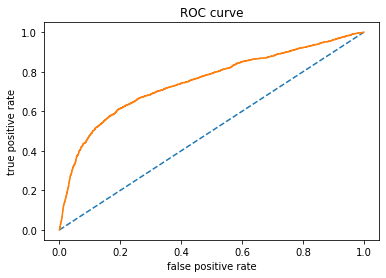

In [220]:
random_seed = 2020 # 2020
np.random.seed(2) # 2
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']

trainx, testx, trainy, testy = train_test_split(df_x, df_y, test_size = 0.2, random_state=random_seed)    # random_state=2020
# 0.2
# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=5, shuffle=True)

xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            #max_depth = 3,
                           )

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(testx)[:,1]

rocxgb=roc_auc_score(testy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, testx, testy)

plot_roc(testy, y_scorexgb)

###################
# 删XGBoost重要特征0的值，不删'mrg_situ_cd'：0.753749656824646， 
# +
# 不删'beh_page_no_TRN': 0.7539486571002911

# 训练

In [8]:
###############################################
################## 2 模型训练 ##################
###############################################
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import StratifiedKFold  
from sklearn.model_selection import KFold  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

################
## 评价函数 
def perfomance_clf(model,X,y,name=None):
    y_predict = model.predict(X)
    y_predict_prob = model.predict_proba(X)[:, 1]
    if name:
        print(name,':')
    print(f'accuracy score is: {accuracy_score(y,y_predict)}')
    print(f'precision score is: {precision_score(y,y_predict)}')
    print(f'recall score is: {recall_score(y,y_predict)}')
    print(f'auc: {roc_auc_score(y,y_predict_prob)}')
    print('- - - - - - ')
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr)#, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()    

roc  0.753749656824646
accuracy score is: 0.8116468378209142
precision score is: 0.6589986468200271
recall score is: 0.28004600345025876
auc: 0.753749656824646
- - - - - - 


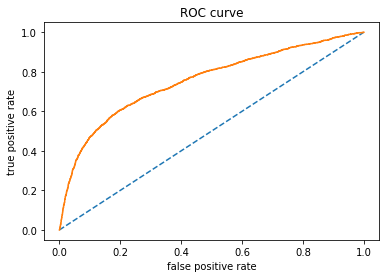

In [14]:
random_seed = 2020 # 2020
np.random.seed(2) # 2
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']

trainx, testx, trainy, testy = train_test_split(df_x, df_y, test_size = 0.2, random_state=random_seed)    # random_state=2020
# 0.2
# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=5, shuffle=True)

xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(testx)[:,1]

rocxgb=roc_auc_score(testy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, testx, testy)

plot_roc(testy, y_scorexgb)

###################
# 删XGBoost重要特征0的值，不删'ovd_30d_loan_tot_cnt', 'mrg_situ_cd'：0.753749656824646

# XGBoost特征重要性

In [9]:
train_x = train_DF_weneed.drop(['flag'], axis = 1)
train_y = train_DF_weneed.flag
colname = train_x.columns.values.tolist()

import xgboost as xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(train_x, train_y)
xgb_feature = sorted(zip(map(lambda x: round(x, 4), xgb_cfl.feature_importances_), colname),  reverse=True)
xgb_feature

[(0.0939, 'l1y_crd_card_csm_amt_dlm_cd'),
 (0.0794, 'dnl_ind'),
 (0.0634, 'cny_trx_income'),
 (0.0555, 'most_Trx_Cod2_Cd'),
 (0.0436, 'gdr_cd'),
 (0.0429, 'most_Trx_Cod1_Cd'),
 (0.0374, 'acdm_deg_cd'),
 (0.0357, 'cny_trx_pay'),
 (0.0356, 'ovd_cnt'),
 (0.0354, 'most_trx_way'),
 (0.031, 'fr_or_sh_ind'),
 (0.0305, 'Dat_Flg1_Cd_C'),
 (0.0229, 'hav_car_grp_ind'),
 (0.0224, 'dnl_bind_cmb_lif_ind'),
 (0.022, 'l6mon_daim_aum_cd'),
 (0.0184, 'pot_ast_lvl_cd'),
 (0.0182, 'cur_credit_min_opn_dt_cnt'),
 (0.0173, 'Dat_Flg3_Cd_B'),
 (0.0123, 'hld_crd_card_grd_cd'),
 (0.0123, 'his_lng_ovd_day'),
 (0.0118, 'cur_credit_card'),
 (0.0117, 'Dat_Flg3_Cd_A'),
 (0.0115, 'perm_crd_lmt_cd'),
 (0.011, 'actual_income'),
 (0.0098, 'cur_debit_min_opn_dt_cnt'),
 (0.0088, 'job_year'),
 (0.0087, 'confirm_rsk_ases_lvl_typ_cd'),
 (0.0086, 'page_type_count'),
 (0.0085, 'beh_page_no_FTR'),
 (0.0083, 'loan_act_ind'),
 (0.0083, 'hav_car_hou_ind'),
 (0.0083, 'beh_page_no_CQA'),
 (0.008, 'beh_page_no_MSG'),
 (0.0076, 'beh_pa

In [10]:
print(len(xgb_feature))
xgb_feature_list = [x[1] for x in xgb_feature]
xgb_feature_score = [x[0] for x in xgb_feature]
#xgb_feature_list[xgb_feature_score.index(0.0)-1:]
xgb_feature_list

93


['l1y_crd_card_csm_amt_dlm_cd',
 'dnl_ind',
 'cny_trx_income',
 'most_Trx_Cod2_Cd',
 'gdr_cd',
 'most_Trx_Cod1_Cd',
 'acdm_deg_cd',
 'cny_trx_pay',
 'ovd_cnt',
 'most_trx_way',
 'fr_or_sh_ind',
 'Dat_Flg1_Cd_C',
 'hav_car_grp_ind',
 'dnl_bind_cmb_lif_ind',
 'l6mon_daim_aum_cd',
 'pot_ast_lvl_cd',
 'cur_credit_min_opn_dt_cnt',
 'Dat_Flg3_Cd_B',
 'hld_crd_card_grd_cd',
 'his_lng_ovd_day',
 'cur_credit_card',
 'Dat_Flg3_Cd_A',
 'perm_crd_lmt_cd',
 'actual_income',
 'cur_debit_min_opn_dt_cnt',
 'job_year',
 'confirm_rsk_ases_lvl_typ_cd',
 'page_type_count',
 'beh_page_no_FTR',
 'loan_act_ind',
 'hav_car_hou_ind',
 'beh_page_no_CQA',
 'beh_page_no_MSG',
 'beh_page_no_AAO',
 'Dat_Flg1_Cd_B',
 'rsk_combine',
 'dnl_mbl_bnk_ind',
 'beh_page_no_JF2',
 'beh_page_no_CQD',
 'age',
 'cur_credit_cnt',
 'most_tms_page_no',
 'rsk_mean',
 'l12_mon_fnd_buy_whl_tms',
 'frs_agn_dt_cnt',
 'fin_rsk_ases_grd_cd',
 'pl_crd_lmt_cd',
 'cust_inv_rsk_endu_lvl_cd',
 'ast_combine',
 'trx_tms',
 'I12_mon_whl_tms',
 '